<a href="https://colab.research.google.com/github/ELehmann91/Thesis_Multilingual_Transferlearning/blob/master/HF_mulitlingunag_Ecoicop_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--<badge>--><a href="https://colab.research.google.com/github/huggingface/workshops/blob/main/machine-learning-tokyo/02-text-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Fine-tuning your first Transformer!

In this notebook we'll take a look at fine-tuning a multilingual Transformer model called [XLM-RoBERTa](https://huggingface.co/xlm-roberta-base) for text classification. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Create a baseline with the zero-shot classification pipeline
* Fine-tune and evaluate pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

## Setup

If you're running this notebook on Google Colab or locally, you'll need a few dependencies installed. You can install them with `pip` as follows:

In [1]:
%%capture
! pip install datasets transformers sentencepiece

To be able to share your model with the community there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-crendential store but this isn't the helper defined on your machine.
You will have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal to set it as the default

git config --global credential.helper store


Then you need to install Git-LFS. Uncomment and execute the following cell:

In [3]:
%%capture
!apt install git-lfs

## The dataset

In this notebook we'll be using the 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

In this tutorial we'll use the [Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) (or MARC for short). This is a large-scale collection of Amazon product reviews in several languages: English, Japanese, German, French, Spanish, and Chinese. 

We can download the dataset from the Hugging Face Hub with the 🤗 Datasets library, but first let's take a look at the available subsets (also called configs):

In [16]:
from datasets import get_dataset_config_names

dataset_name = "amazon_reviews_multi"
langs = get_dataset_config_names(dataset_name)
langs

Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

['all_languages', 'de', 'en', 'es', 'fr', 'ja', 'zh']

Okay, we can see the language codes associated with each language, as well as an `all_languages` subset which presumably concatenates all the languages together. Let's begin by downloading the English subset with the `load_dataset()` function from 🤗 Datasets:

In [6]:
from datasets import load_dataset
#marc_en = load_dataset(path=dataset_name, name="all_languages")
#marc_en

One cool feature of 🤗 Datasets is that `load_dataset()` will cache the files at `~/.cache/huggingface/dataset/`, so you won't need to re-download the dataset the next time your run the notebook. 

We can see that `marc_en` is a `DatasetDict` object which is similar to a Python dictionary, with each key corresponding to a different split. We can access an element of one of these splits as follows:

In [ ]:
# Peek at first element
marc_en["train"][0]

This certainly looks like an Amazon product review and we can see the number of stars associated with the review, as well as some metadata like the language and product category.

We can also access several rows with a slice:

In [ ]:
marc_en["train"][:3]

and note that now we get a list of values for each column. This is because 🤗 Datasets is based on Apache Arrow, which defines a typed columnar format that is very memory efficient.

### What if my dataset is not on the Hub?

Note that altough we downloaded the dataset from the Hub, it's also possible to load datasets both locally and from custom URLs. For example, the above dataset lives at the following URL:

We can then load it locally using the `json` loading script:

In [4]:
import pandas as pd
from google.colab import drive, files

drive.mount('/content/gdrive')
path ='/content/gdrive/My Drive/Thesis_ecb_ecoicop'
data_path = '/data/'#

Mounted at /content/gdrive


In [7]:
dataset_de = load_dataset("csv", data_files=path+data_path+'german_preprocessed_s.csv', split='train')
dataset_de

Using custom data configuration default-8d566bb51707f65c


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8d566bb51707f65c/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Dataset({
    features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
    num_rows: 31463
})

In [8]:
dataset_fr = load_dataset("csv", data_files=path+data_path+'french_preprocessed_s.csv', split='train')
dataset_fr

Using custom data configuration default-82a3b848dcbf4a1b


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-82a3b848dcbf4a1b/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Dataset({
    features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
    num_rows: 22833
})

In [12]:
dataset_it = load_dataset("csv", data_files=path+data_path+'italia_preprocessed_s.csv', split='train')
dataset_it

Using custom data configuration default-c4cb4bffcdda3611


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c4cb4bffcdda3611/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


Dataset({
    features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
    num_rows: 667
})

In [17]:
from datasets import  concatenate_datasets
dataset_de_fr = concatenate_datasets([dataset_de,dataset_fr,dataset_it])
dataset_de_fr

Dataset({
    features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
    num_rows: 54963
})

In [18]:
dataset_de_fr = dataset_de_fr.shuffle()

In [19]:
train_testvalid = dataset_de_fr.train_test_split()
train_testvalid

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
        num_rows: 41222
    })
    test: Dataset({
        features: ['Unnamed: 0', 'lang', 'cc5', 'shop', 'text'],
        num_rows: 13741
    })
})

Now that we've had a quick look at the objects in 🤗 Datasets, let's explore the data in more detail by using our favourite tool - Pandas!

## From Datasets to DataFrames and back

🤗 Datasets is designed to be interoperable with libraries like Pandas, as well as NumPy, PyTorch, TensorFlow, and JAX. To enable the conversion between various third-party libraries, 🤗 Datasets provides a Dataset.set_format() function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format which is Apache Arrow. The formatting is done in-place, so let’s convert our dataset to Pandas and look at a random sample:

In [20]:
from IPython.display import display, HTML

train_testvalid.set_format("pandas")
df = train_testvalid["train"][:]
# Create a random sample
sample = df.sample(n=1, random_state=42)
display(HTML(sample.to_html()))

,Unnamed: 0,lang,cc5,shop,text
11635,5887,de,9999_Non-Food,Spar,Haushalt Haushaltszubehör Kerzen & Raumdüfte <sep> shop lebensmittel simpex color teelicht maxi orchidee stk <sep> SIMPEX Color Teelicht Maxi Orchidee 12 Stk.


We can see that the column headers are the same as we saw in the Arrow format and from the reviews we can see that negative reviews are associated with a lower star rating. Since we're now dealing with a `pandas.DataFrame` we can easily query our dataset. For example, let's see what the distribution of reviews per product category looks like: 

In [21]:
df["cc5"].value_counts()

9999_Non-Food                    8212
2121_Wine from grapes            2677
1145_Cheese and curd             2149
1211_Coffee                      1877
1183_Chocolate                   1733
                                 ... 
2203_Other tobacco products        35
1155_Other edible animal fats      34
2112_Alcoholic soft drinks         29
2123_Fortified wines               27
2202_Cigars                         9
Name: cc5, Length: 75, dtype: int64

In [22]:
labels = df["cc5"].unique()
labels[:2]

array(['1185_Edible ices and ice cream',
       '1116_Pasta products and couscous'], dtype=object)

Okay, the `home`, `wireless`, and `sports` categories seem to be the most popular. How about the distribution of star ratings?

In [23]:
train_testvalid.reset_format()

## Filtering for a product category

Although we could go ahead and fine-tune a Transformer model on the whole set of 200,000 English reviews, this will take several hours on a single GPU. So instead, we'll focus on fine-tuning a model for a single product category! In 🤗 Datasets, we can filter data very quickly by using the `Dataset.filter()` method. This method expects a function that returns Boolean values, in our case `True` if the `product_category` matches the chosen category and `False` otherwise. Here's one way to implement this, and we'll pick the `sports` category as the domain to train on:

In [ ]:
product_category = "grocery"

def filter_for_product(example, product_category=product_category):
    return example["product_category"] == product_category

Now when we pass `filter_for_product()` to `Dataset.filter()` we get a filtered dataset:

In [ ]:
product_dataset = marc_en.filter(filter_for_product)
product_dataset

  0%|          | 0/1200 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 23718
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 602
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 604
    })
})

Yep, this looks good - we have 13,748 reviews in the train split which agrees the number we saw in the distribution of categories earlier. Let's do a quick sanity check by taking a look at a few samples. Here 🤗 Datasets provides `Dataset.shuffle()` and `Dataset.select()` functions that we can chain to get a random sample:

In [ ]:
product_dataset["train"].shuffle(seed=42).select(range(3))[:]

Okay, now that we have our corpus of book reviews, let's do one last bit of data preparation: creating label mappings from star ratings to human readable strings.

## Mapping the labels

During training, 🤗 Transformers expects the labels to be ordered, starting from 0 to N. But we've seen that our star ratings range from 1-5, so let's fix that. While we're at it, we'll create a mapping between the label IDs and names, which will be handy later on when we want to run inference with our model. First we'll define the label mapping from ID to name:

In [24]:
label_names = labels #["terrible", "poor", "ok", "good", "great"]
id2label = {idx:label for idx, label in enumerate(label_names)}
#id2label

In [25]:
label_names = labels #["terrible", "poor", "ok", "good", "great"]
label2id = {label:idx for idx, label in enumerate(label_names)}
#label2id

We can then apply this mapping to our whole dataset by using the `Dataset.map()` method. Similar to the `Dataset.filter()` method, this one expects a function which receives examples as input, but returns a Python dictionary as output. The keys of the dictionary correspond to the columns, while the values correspond to the column entries. The following function creates two new columns:

* A `labels` column which is the star rating shifted down by one
* A `label_name` column which provides a nice string for each rating

In [26]:
def map_labels(example):
    # Shift labels to start from 0
    label_id = label2id[example["cc5"]]
    return {"labels": label_id, "label_name": id2label[label_id]}

To apply this mapping, we simply feed it to `Dataset.map` as follows:

In [27]:
train_testvalid = train_testvalid.map(map_labels)
# Peek at the first example
train_testvalid["train"][0]

  0%|          | 0/41222 [00:00<?, ?ex/s]

  0%|          | 0/13741 [00:00<?, ?ex/s]

{'Unnamed: 0': 200810,
 'cc5': '1185_Edible ices and ice cream',
 'label_name': '1185_Edible ices and ice cream',
 'labels': 0,
 'lang': 'de',
 'shop': 'shop.rewe.de',
 'text': 'Tiefkühl Eiscreme & Eiswürfel Eis-Desserts <sep> snickers ice cream <sep> Snickers Ice Cream 6x53ml'}

Great, it works! We'll also need the reverse label mapping later, so let's define it here: 

In [ ]:
label2id = {v:k for k,v in id2label.items()}

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called _tokenization_. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors. 

For more information about tokenizers, check out the following video:

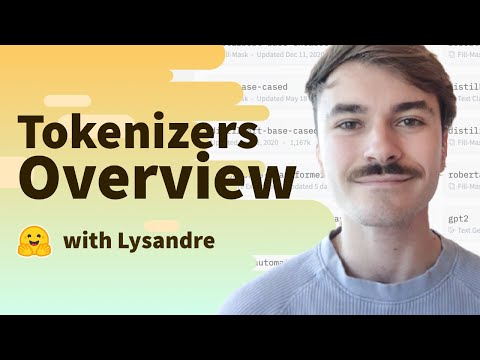

In [ ]:
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

Each pretrained model comes with its own tokenizer, so to get started let's download the tokenizer of XLM-RoBERTa from the Hub:

In [28]:
from transformers import AutoTokenizer

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

The tokenizer has a few interesting attributes such as the vocabulary size:

In [29]:
tokenizer.vocab_size

250002

This tells us that XLM-R has 250,002 tokens that is can use to represent text with. Some of the tokens are called _special tokens_ to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. Here's what the special tokens look like for XLM-R:

In [30]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [31]:
encoded_str = tokenizer("Today I'm giving an NLP workshop at MLT")
encoded_str

{'input_ids': [0, 38396, 87, 25, 39, 68772, 142, 541, 37352, 42819, 99, 276, 27026, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [32]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

0 <s>
38396 Today
87 I
25 '
39 m
68772 giving
142 an
541 N
37352 LP
42819 workshop
99 at
276 M
27026 LT
2 </s>


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. As before, we'll do this with `Dataset.map()` so let's write a simple function to do so:

In [33]:
def tokenize_reviews(examples):
    return tokenizer(examples["text"], truncation=True, max_length=80)

Here we've enabled truncation, so the tokenizer will cut any inputs that are longer than 180 tokens (which is the setting used in the MARC paper). With this function we can go ahead and tokenize the whole corpus:

In [34]:
tokenized_dataset = train_testvalid.map(tokenize_reviews, batched=True)
tokenized_dataset

  0%|          | 0/42 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'attention_mask', 'cc5', 'input_ids', 'label_name', 'labels', 'lang', 'shop', 'text'],
        num_rows: 41222
    })
    test: Dataset({
        features: ['Unnamed: 0', 'attention_mask', 'cc5', 'input_ids', 'label_name', 'labels', 'lang', 'shop', 'text'],
        num_rows: 13741
    })
})

In [35]:
tokenized_dataset["train"][0]

{'Unnamed: 0': 200810,
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'cc5': '1185_Edible ices and ice cream',
 'input_ids': [0,
  150192,
  92,
  109833,
  104331,
  7612,
  282,
  619,
  104331,
  233327,
  141,
  104331,
  9,
  73347,
  33657,
  7,
  4426,
  70637,
  2740,
  91,
  67127,
  1314,
  6,
  2980,
  24709,
  4426,
  70637,
  2740,
  159,
  67127,
  1314,
  65058,
  53822,
  305,
  425,
  14226,
  7237,
  2],
 'label_name': '1185_Edible ices and ice cream',
 'labels': 0,
 'lang': 'de',
 'shop': 'shop.rewe.de',
 'text': 'Tiefkühl Eiscreme & Eiswürfel Eis-Desserts <sep> snickers ice cream <sep> Snickers Ice Cream 6x53ml'}

This looks good, so now let's load a pretrained model!

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with 5 classes (one for each star) so to initialise the model we'll provide this information along with the label mappings:

In [36]:
len(labels)

75

In [37]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, the next step is to initialise a `Trainer` that will take care of the training loop for us. Let's do that next.

## Creating a Trainer

To create a `Trainer`, we usually need a few basic ingredients:

* A `TrainingArguments` class to define all the hyperparameters
* A `compute_metrics` function to compute metrics during evaluation
* Datasets to train and evaluate on

For more information about the `Trainer` check out the following video:

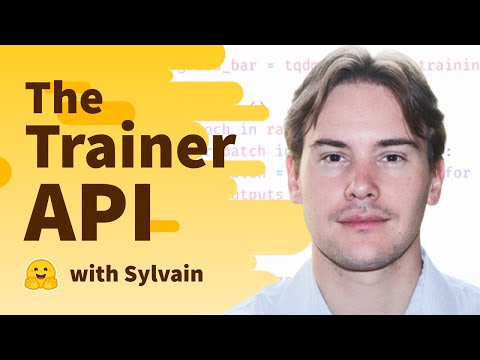

In [ ]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

Let's start with the `TrainingArguments`:

In [38]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]
batch_size = 16
num_train_epochs = 5
logging_steps = len(tokenized_dataset["train"]) // (batch_size * num_train_epochs)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-ecoicop",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    logging_steps=logging_steps,
    push_to_hub=True,
)

Here we've defined `output_dir` to save our checkpoints and tweaked some of the default hyperparameters like the learning rate and weight decay. The `push_to_hub` argument will push each checkpoint to the Hub automatically for us, so we can reuse the model at any point in the future!

Now that we've defined the hyperparameters, the next step is to define the metrics. In the MARC paper, the authors point out that one should use the mean absolute error (MAE) for star ratings because:

> star ratings for each review are ordinal, and a 2-star prediction for a 5-star review should be penalized more heavily than a 4-star prediction for a 5-star review.

We'll take the same approach here and we can get the metric easily from Scikit-learn as follows:

In [39]:
import numpy as np
from sklearn.metrics import mean_absolute_error, accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"Acc": accuracy_score(labels, predictions)}

With these ingredients we can now instantiate a `Trainer`:

In [40]:
tokenized_dataset['train']

Dataset({
    features: ['Unnamed: 0', 'attention_mask', 'cc5', 'input_ids', 'label_name', 'labels', 'lang', 'shop', 'text'],
    num_rows: 41222
})

In [41]:
tokenized_dataset["test"]

Dataset({
    features: ['Unnamed: 0', 'attention_mask', 'cc5', 'input_ids', 'label_name', 'labels', 'lang', 'shop', 'text'],
    num_rows: 13741
})

In [42]:
from transformers import Trainer 

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop into local empty directory.


Note that here we've also provided the tokenizer to the `Trainer`: doing so will ensure that all of our examples are automatically padded to the longest example in each batch. This is needed so that matrix operations in the forward pass of the model can be computed. 

With our `Trainer`, it is then a simple matter to train the model:

In [43]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, text, lang, cc5, shop, Unnamed: 0.
***** Running training *****
  Num examples = 41222
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12885


Epoch,Training Loss,Validation Loss,Acc
1,0.422400,0.361159,0.913180
2,0.231300,0.250984,0.944109
3,0.174600,0.192829,0.956917
4,0.132500,0.173114,0.964049


The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, text, lang, cc5, shop, Unnamed: 0.
***** Running Evaluation *****
  Num examples = 13741
  Batch size = 16
Saving model checkpoint to xlm-roberta-base-finetuned-ecoicop/checkpoint-2577
Configuration saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-2577/config.json
Model weights saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-2577/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-2577/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-2577/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-ecoicop/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-ecoicop/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `XLM

Epoch,Training Loss,Validation Loss,Acc
1,0.422400,0.361159,0.913180
2,0.231300,0.250984,0.944109
3,0.174600,0.192829,0.956917
4,0.132500,0.173114,0.964049
5,0.094600,0.168454,0.965869


The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, text, lang, cc5, shop, Unnamed: 0.
***** Running Evaluation *****
  Num examples = 13741
  Batch size = 16
Saving model checkpoint to xlm-roberta-base-finetuned-ecoicop/checkpoint-12885
Configuration saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-12885/config.json
Model weights saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-12885/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-12885/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-ecoicop/checkpoint-12885/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=12885, training_loss=0.35500334654383575, metrics={'train_runtime': 2481.0878, 'train_samples_per_second': 83.072, 'train_steps_per_second': 5.193, 'total_flos': 6925689139051584.0, 'train_loss': 0.35500334654383575, 'epoch': 5.0})

Nice, with just a few mintues of training, we've managed to halve our error compared to the zero-shot baseline! After training is complete, we can push the commits to our repository on the Hub:

In [44]:
trainer.push_to_hub(commit_message="Training complete!")

Saving model checkpoint to xlm-roberta-base-finetuned-ecoicop
Configuration saved in xlm-roberta-base-finetuned-ecoicop/config.json
Model weights saved in xlm-roberta-base-finetuned-ecoicop/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-ecoicop/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-ecoicop/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.37k/1.04G [00:00<?, ?B/s]

Upload file runs/Oct27_07-48-28_cb8cbc9ba39d/events.out.tfevents.1635320949.cb8cbc9ba39d.75.0:  23%|##3       …

To https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop
   2c88581..cdc3a09  main -> main

Dropping the following result as it does not have all the necessary field:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop
   cdc3a09..4702ced  main -> main



'https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/commit/cdc3a0983affba750f5ba428a844805bdf955af8'

## Evaluating cross-lingual transfer

Now that we're fine-tuned our model on a English subset, we can evaluate its ability to transfer to other languages. To do so, we'll load the validation set in a given language, apply the same filtering and preprocessing that we did for the English subset, and finally use `Trainer.evaluate()` to compute the metrics. The following function does the trick: 

In [45]:
dataset_fr
dataset_fr = dataset_fr.map(map_labels)
tokenized_dataset = dataset_fr.map(tokenize_reviews, batched=True)
preds = trainer.evaluate(eval_dataset=tokenized_dataset)
preds

  0%|          | 0/22833 [00:00<?, ?ex/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, text, lang, cc5, shop, Unnamed: 0.
***** Running Evaluation *****
  Num examples = 22833
  Batch size = 16


In [47]:
dataset_it
dataset_it = dataset_it.map(map_labels)
tokenized_dataset = dataset_it.map(tokenize_reviews, batched=True)
preds = trainer.evaluate(eval_dataset=tokenized_dataset)
preds

  0%|          | 0/667 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: label_name, text, lang, cc5, shop, Unnamed: 0.
***** Running Evaluation *****
  Num examples = 667
  Batch size = 16


{'epoch': 5.0,
 'eval_Acc': 0.8935532233883059,
 'eval_loss': 0.4839481711387634,
 'eval_runtime': 1.2372,
 'eval_samples_per_second': 539.123,
 'eval_steps_per_second': 33.948}

In [ ]:
def evaluate_corpus(lang):
    # Load the language subset
    dataset = load_dataset(dataset_name, lang, split="validation")
    # Filter for the `sports` product category
    product_dataset = dataset.filter(filter_for_product)
    # Map and create label columns
    product_dataset = product_dataset.map(map_labels)
    # Tokenize the inputs
    tokenized_dataset = product_dataset.map(tokenize_reviews, batched=True)
    # Generate predictions and metrics
    preds = trainer.evaluate(eval_dataset=tokenized_dataset)
    return {"MAE": preds["eval_MAE"]}

Let's start with English (for reference our MAE on English was around 0.5):

In [ ]:
evaluate_corpus("fr")

NameError: ignored

Not bad! Our fine-tuned English model is able to transfer to English at roughly the same performance. How about French?

In [ ]:
evaluate_corpus("ja")

Reusing dataset amazon_reviews_multi (/data/.cache/hf/datasets/amazon_reviews_multi/ja/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/ja/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-a0b282f870bb7c27.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/ja/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-f5ab579eace2ea64.arrow
Loading cached processed dataset at /data/.cache/hf/datasets/amazon_reviews_multi/ja/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e0443037d9ae83f1.arrow
The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: product_id, review_title, label_name, stars, review_body, review_id, reviewer_id, language, product_category.
***** Running Evaluatio

{'MAE': 0.6776859504132231}

Nice, this is very similar too! This shows the great power of multilingual models - provided your target language was included in the pretraining, there's a good chance you'll only need to tune and deploy a single model in production instead of running one per language. 

This wraps up our training and evaluation step - one last thing to try is seeing how we can interact with our model in a `pipeline`.

## Using your fine-tuned model

In [48]:
from transformers import pipeline 

finetuned_checkpoint = "peter2000/xlm-roberta-base-finetuned-ecoicop"
classifier = pipeline("text-classification", model=finetuned_checkpoint)

https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwesd153l


Downloading:   0%|          | 0.00/6.29k [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/dd2de7518f860c63bcab28246f666951c4d7bb22ce5e3f0afc097a984fc96aab.bf00b5627699e9c6f7d79a458f776bc57d5aff48595e33bb366189e4ceb9a9f3
creating metadata file for /root/.cache/huggingface/transformers/dd2de7518f860c63bcab28246f666951c4d7bb22ce5e3f0afc097a984fc96aab.bf00b5627699e9c6f7d79a458f776bc57d5aff48595e33bb366189e4ceb9a9f3
loading configuration file https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dd2de7518f860c63bcab28246f666951c4d7bb22ce5e3f0afc097a984fc96aab.bf00b5627699e9c6f7d79a458f776bc57d5aff48595e33bb366189e4ceb9a9f3
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout":

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/da92dc0d9f359e59ee12e0114cdbbab205af4bd52c7f82e378f38aa2a68a808b.21ed62e526319708fa6c3003c456e65020ec28d7acf40d29e0341a6d64ae1be2
creating metadata file for /root/.cache/huggingface/transformers/da92dc0d9f359e59ee12e0114cdbbab205af4bd52c7f82e378f38aa2a68a808b.21ed62e526319708fa6c3003c456e65020ec28d7acf40d29e0341a6d64ae1be2
loading weights file https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/da92dc0d9f359e59ee12e0114cdbbab205af4bd52c7f82e378f38aa2a68a808b.21ed62e526319708fa6c3003c456e65020ec28d7acf40d29e0341a6d64ae1be2
All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at peter2000/xlm-robert

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/5f1c25a7d196cb8126ec24d83bbf38019ed1bfda93ae4080278865bf0ebbca4c.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
creating metadata file for /root/.cache/huggingface/transformers/5f1c25a7d196cb8126ec24d83bbf38019ed1bfda93ae4080278865bf0ebbca4c.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2vv_qyjr


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/fe68bb46984f51fec1bd2839ac26e58beee3d33f7fdb28ca06308f69a2ceb251.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
creating metadata file for /root/.cache/huggingface/transformers/fe68bb46984f51fec1bd2839ac26e58beee3d33f7fdb28ca06308f69a2ceb251.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp16yktb2y


Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/c100d7dab65ee0bfb7b54ae8c79a57cc4b6d0ba23da791d4fedad282ffc6fd3a.a3b1d1ab4fbe41e81da4e31a6b11eab90ced91130f592dd59b933bccf4751b6b
creating metadata file for /root/.cache/huggingface/transformers/c100d7dab65ee0bfb7b54ae8c79a57cc4b6d0ba23da791d4fedad282ffc6fd3a.a3b1d1ab4fbe41e81da4e31a6b11eab90ced91130f592dd59b933bccf4751b6b
https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpg0rw7lsz


Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

storing https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/9024d08c89b951ba679b5a6517b3a74a41275798d06a1642679ab6639caa860d.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
creating metadata file for /root/.cache/huggingface/transformers/9024d08c89b951ba679b5a6517b3a74a41275798d06a1642679ab6639caa860d.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
loading file https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/fe68bb46984f51fec1bd2839ac26e58beee3d33f7fdb28ca06308f69a2ceb251.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
loading file https://huggingface.co/peter2000/xlm-roberta-base-finetuned-ecoicop/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/c100d7dab65ee0bfb7b54ae8c79a57cc4b6d0ba23da791d4fed

In [49]:
classifier("Schwartau Frühstücksmarmelade mit ")

[{'label': '1182_Jams, marmalades and honey', 'score': 0.9867764115333557}]

In [57]:
classifier("Filetes de merluza sin piel PESCANOVA, bolsa 400 g 1 KILO A 10,98 €")

[{'label': '1136_Other preserved or processed fish and seafood-based preparations',
  'score': 0.8314335346221924}]

# SageMaker

In [58]:
!pip install sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [59]:
import sagemaker
import boto3
from sagemaker.huggingface import HuggingFace

# gets role for executing training job
iam_client = boto3.client('iam')
role = iam_client.get_role(RoleName='{IAM_ROLE_WITH_SAGEMAKER_PERMISSIONS}')['Role']['Arn']
hyperparameters = {
	'model_name_or_path':'peter2000/xlm-roberta-base-finetuned-ecoicop',
	'output_dir':'/opt/ml/model'
	# add your remaining hyperparameters
	# more info here https://github.com/huggingface/transformers/tree/v4.6.1/examples/pytorch/text-classification
}

# git configuration to download our fine-tuning script
git_config = {'repo': 'https://github.com/huggingface/transformers.git','branch': 'v4.6.1'}

# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='run_glue.py',
	source_dir='./examples/pytorch/text-classification',
	instance_type='ml.p3.2xlarge',
	instance_count=1,
	role=role,
	git_config=git_config,
	transformers_version='4.6.1',
	pytorch_version='1.7.1',
	py_version='py36',
	hyperparameters = hyperparameters
)

# starting the train job
huggingface_estimator.fit()

NoCredentialsError: ignored